In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import ydata_profiling

In [3]:
# Load data

import pandas as pd

df = pd.read_csv("hf://datasets/GB2024/diabetes/diabetes_prediction_dataset.csv")

In [4]:
# Exploratory data analysis of data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
# check missing values
df.isnull().any()

gender                 False
age                    False
hypertension           False
heart_disease          False
smoking_history        False
bmi                    False
HbA1c_level            False
blood_glucose_level    False
diabetes               False
dtype: bool

In [6]:
# check duplicates

df.duplicated().sum()



3854

In [7]:
# drop duplicates

df.drop_duplicates(inplace=True)

In [15]:
profile = ydata_profiling.ProfileReport(df)

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

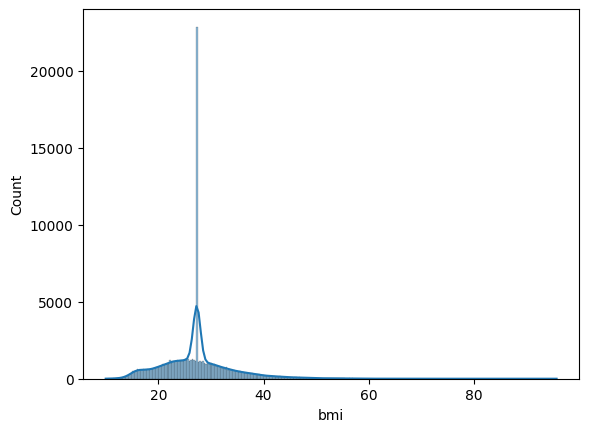

In [11]:
# Check distribution of variables 

sns.histplot(df['bmi'], kde = True)
plt.show()

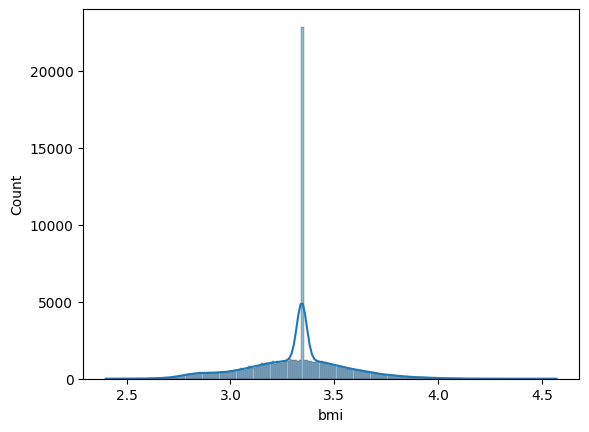

In [12]:
# Performing a log transformation

df_log1p = np.log1p(df['bmi'])
sns.histplot(df_log1p, kde = True)
plt.show()

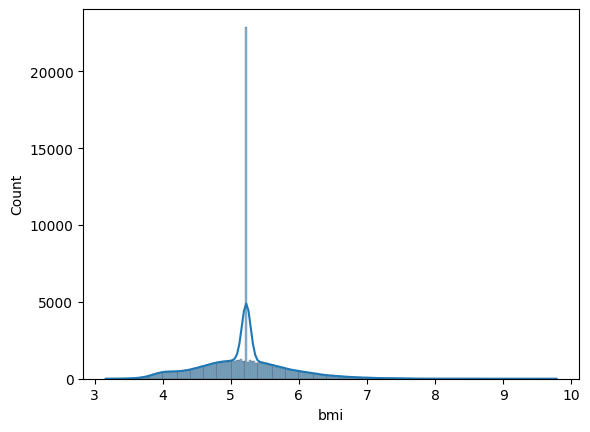

In [13]:
# Performing sqrt transform

df_sqrt = np.sqrt(df['bmi'])

sns.histplot(df_sqrt, kde = True)
plt.show()

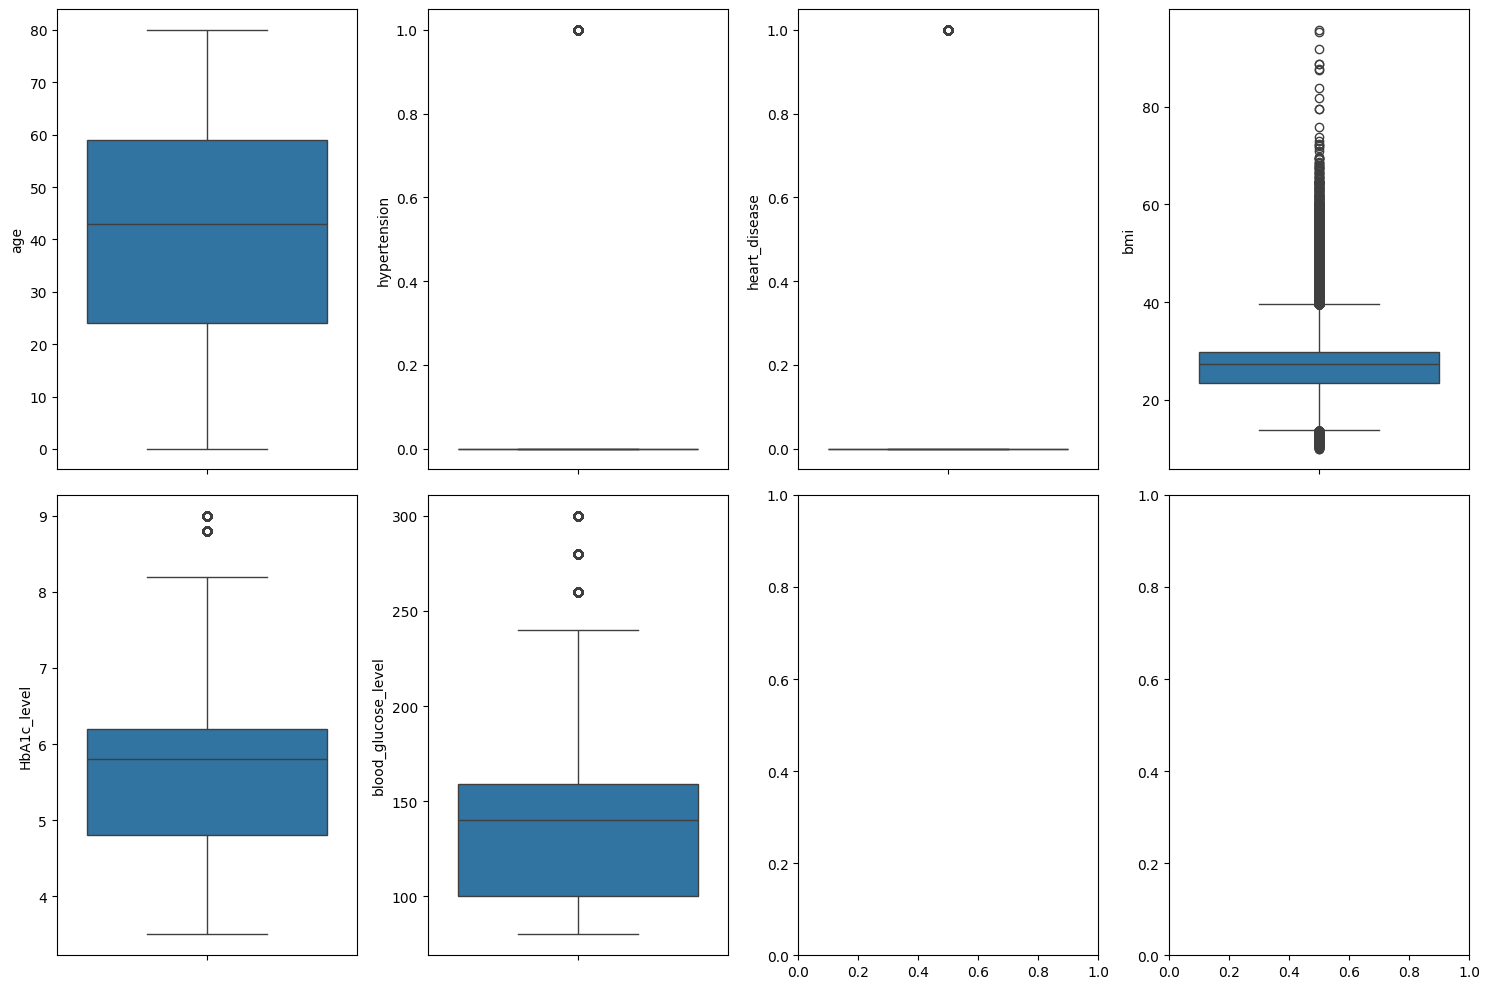

In [10]:
num_cols = [col for col in df.select_dtypes(include = 'number').columns if col not in ['diabetes']]

fig, axes = plt.subplots(2, 4, figsize  = (15,10))

for i, col in enumerate(num_cols):
    row, col_position = divmod(i, 4)
    sns.boxplot(data = df, y = col, ax = axes[row, col_position])
    plt.tight_layout()

plt.show()

In [14]:
#remove outliers

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


for column in num_cols:
    df = remove_outliers(df, column)

In [ ]:
# Encode categorical variables

df['gender'] = df['gender'].astype('category').cat.codes
df['smoking_history'] = df['smoking_history'].astype('category').cat.codes


1        0
2        4
3        1
5        4
6        4
        ..
99994    0
99996    0
99997    3
99998    4
99999    1
Name: smoking_history, Length: 79194, dtype: int8

In [28]:
X = df.drop(columns = 'diabetes')
y = df['diabetes']

In [29]:
X.shape

(79194, 8)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=2024)

In [36]:
import joblib

scaler = StandardScaler()

X_train = scaler.fit_transform(x_train)

X_test = scaler.transform(x_test)


joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [32]:
#Modeling

model_xgb = xgb.XGBClassifier(seed = 2024)

model_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
#EVALUATE MODEL

y_pred = model_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9806050810647002


In [34]:
#Optimizing using Optuna

def objective(trial):

    params = {
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [35]:
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=50)

[I 2024-12-15 11:44:11,159] A new study created in memory with name: no-name-b756befa-54ed-4fb3-aa9c-ffe50f434f37
[I 2024-12-15 11:44:14,218] Trial 0 finished with value: 0.9810596494772463 and parameters: {'learning_rate': 0.01507931224517399, 'max_depth': 8, 'subsample': 0.5786476920342223, 'colsample_bytree': 0.36925603944503005, 'min_child_weight': 9}. Best is trial 0 with value: 0.9810596494772463.
[I 2024-12-15 11:44:16,595] Trial 1 finished with value: 0.9811606646800344 and parameters: {'learning_rate': 0.007144009297539137, 'max_depth': 10, 'subsample': 0.8939929335423341, 'colsample_bytree': 0.969752015037276, 'min_child_weight': 17}. Best is trial 1 with value: 0.9811606646800344.
[I 2024-12-15 11:44:18,658] Trial 2 finished with value: 0.9811101570786404 and parameters: {'learning_rate': 0.00300974591486369, 'max_depth': 8, 'subsample': 0.4174689763820231, 'colsample_bytree': 0.7604202372896018, 'min_child_weight': 11}. Best is trial 1 with value: 0.9811606646800344.
[I 202

In [37]:
study.best_trial.value

0.9811606646800344

In [38]:
study.best_trial.params

{'learning_rate': 0.007144009297539137,
 'max_depth': 10,
 'subsample': 0.8939929335423341,
 'colsample_bytree': 0.969752015037276,
 'min_child_weight': 17}

In [39]:
# save the model

best_params = study.best_trial.params

best_model = xgb.XGBClassifier(**best_params)

best_model.fit(X_train, y_train)

import joblib

joblib.dump(best_model, 'best_xgb_model.joblib')

['best_xgb_model.joblib']